# <center><font color='magenta'>**Geospatial Data Science - Final Project**</font></center>
### <center>Central European University, 2024-2025</center>

### 2300715 - Saad Joiya

### Finding Optimal Location for Emergency Center in London, UK

# Problem Proposal and Framing

**Objective:**

Determine the optimal locations for new emergency centers (e.g., hospitals, ambulance hubs) in London, based on gaps in existing service coverage, accident hotspots, and high population density zones.

**Why London?**

London is one of the most popular cities in the world. It is known for its development, infrastructure and quality of life. But still there can be gaps present in emergency access that can be rectified. We will analyse the gaps based on population density, accident hotspots and existing coverage for emergency services. We will do this using:

Health and safety datasets

Open road networks

Detailed demographic information

This allows a multi-layered spatial decision model that mimics real-world planning scenarios.

# Importing Libraries

In [5]:
import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from shapely.geometry import Point
import osmnx as ox
from rasterio.mask import mask
import json
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import mapping
from rasterio.plot import show
import contextily as ctx
from shapely.geometry import Point
from rtree import index
import numpy as np
from shapely.strtree import STRtree
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
import time

# Data Collection And Data Exploration

## Boundary of London

We are collecting and visualizing key physical features of Greater London, including administrative boundaries, parks, green areas, and water bodies first. We are using OpenStreetMaps (OSM) with appropriate tag filters to get these elements. 

We use EPSG = 32630	as it is specific to UK and units for it are in Meters.	This is used for buffering, spatial joins and calcuating accurate distance.

In [9]:
# Set CRS for spatial analysis (UTM zone for London)

TARGET_EPSG = 32630

# Getting London Boundary
place_name = "Greater London, United Kingdom"
boundary = ox.geocode_to_gdf(place_name)
boundary = boundary.to_crs(epsg=TARGET_EPSG)


# Loading parks and green areas
tags_parks = {"leisure": "park", "landuse": "grass", "natural": "wood"}
parks = ox.features_from_place(place_name, tags_parks)
parks = parks.to_crs(epsg=TARGET_EPSG)

# Loading water features (rivers, lakes)
tags_water = {"natural": "water", "waterway": True}
water = ox.features_from_place(place_name, tags_water)
water = water.to_crs(epsg=TARGET_EPSG)


CRS transformations are done to align layers spatially and match with the basemap provider.

C:\Users\saad\AppData\Local\Temp\ipykernel_46872\1629696623.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


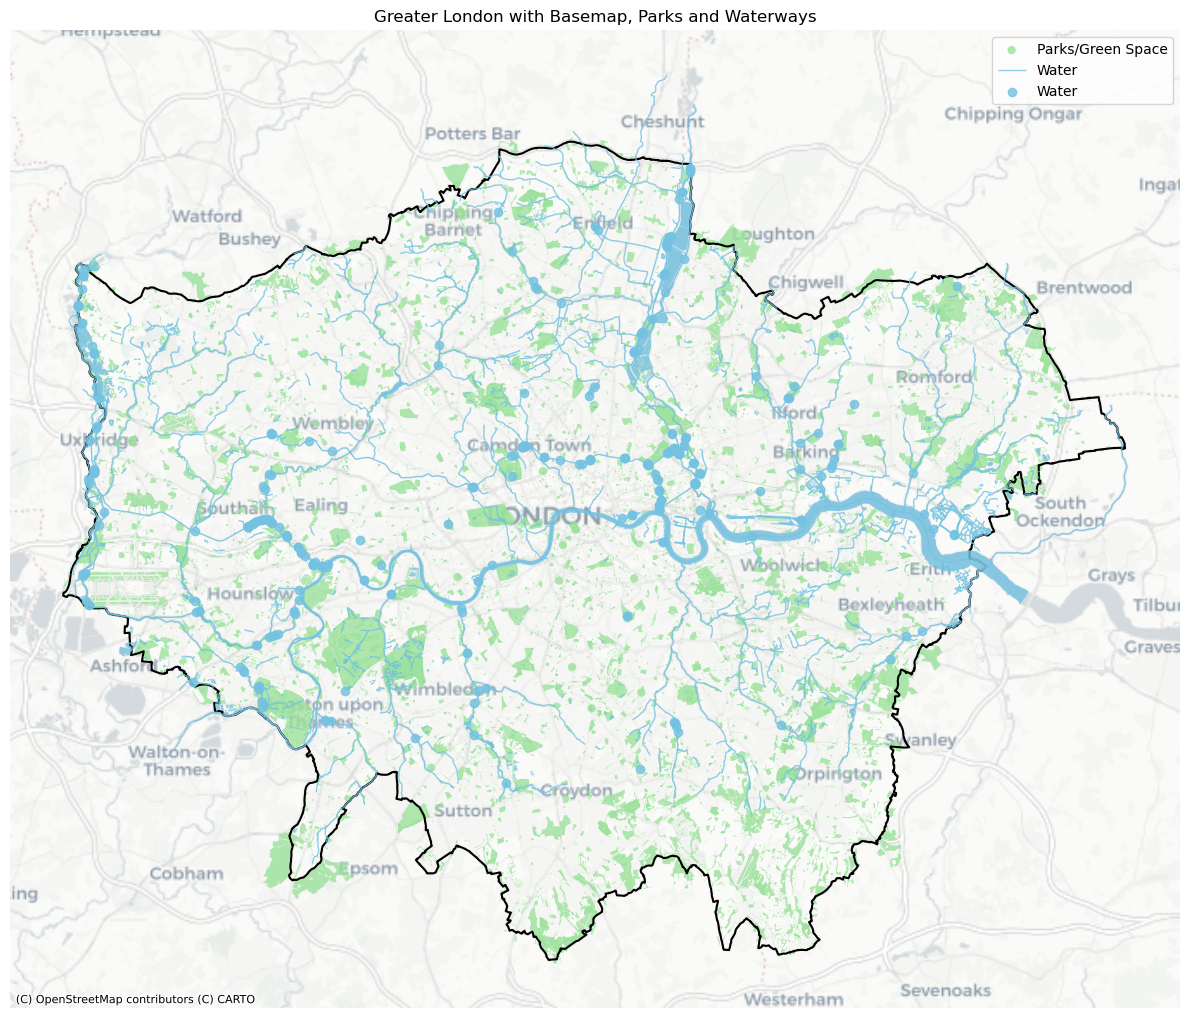

In [11]:

# First, reprojecting all to Web Mercator for basemaps (EPSG:3857)
boundary_web = boundary.to_crs(epsg=3857)
parks_web = parks.to_crs(epsg=3857)
water_web = water.to_crs(epsg=3857)

# Plotting basemap
fig, ax = plt.subplots(figsize=(12, 12))
parks_web.plot(ax=ax,  color='#9be29b', edgecolor='none', alpha=0.8, label="Parks/Green Space", zorder=1)
boundary_web.plot(ax=ax,facecolor='none', edgecolor='black', linewidth=1.5, label="London Boundary", zorder=1)
water_web.plot(ax=ax, color='#74c2e1', linewidth=1, alpha=0.8, label="Water", zorder=1)


ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.title("Greater London with Basemap, Parks and Waterways")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



**Initial map with foundational layers with indication of boundary, parks, waterways and spatial constraints**

## Emergency Services

**Using OSM again to extract geopandas dataframe for emergency services such as hospitals, clinics, fire station and ambulance stations. We then use point geometries from geopandas dataframe to get actual locations**

In [15]:
# Downloading Emergency Services (hospitals, clinics, fire stations, ambulance stations)
tags = {
    "amenity": ["hospital", "clinic", "fire_station"],
    "emergency": ["ambulance_station"]
}
emergency_services = ox.features_from_place(place_name, tags)
gdf_services = emergency_services[emergency_services.geometry.type == 'Point'].copy()
gdf_services = gdf_services.to_crs(epsg=TARGET_EPSG)


In [16]:
gdf_services.head()

geometry       amenity  check_date  \
element id                                                                    
node    26992679   POINT (705349.894 5703220.101)  fire_station  2023-06-17   
        33717225   POINT (698522.398 5693972.831)  fire_station         NaN   
        251007783  POINT (707295.171 5724093.767)  fire_station         NaN   
        254005151  POINT (699428.515 5724050.112)      hospital         NaN   
        255010164  POINT (699265.217 5718450.172)        clinic         NaN   

                  level     created_by                                  name  \
element id                                                                     
node    26992679      0            NaN                                   NaN   
        33717225    NaN           JOSM  Beddington & Wallington Fire Station   
        251007783   NaN  Potlatch 0.7b                Chingford Fire Station   
        254005151   NaN            NaN                       Priory Hospital   
        255010164   NaN            NaN              Crouch End Health Centre   

                  addr:city    addr:housename addr:postcode  addr:street  ...  \
element id                                                                ...   
node    26992679        NaN               NaN           NaN          NaN  ...   
        33717225        NaN               NaN           NaN          NaN  ...   
        251007783       NaN               NaN           NaN          NaN  ...   
        254005151    London  Grovelands House       N14 6RA   The Bourne  ...   
        255010164    London               NaN           NaN  Middle Lane  ...   

                  number roof:orientation service reg_name cadet  \
element id                                                         
node    26992679     NaN              NaN     NaN      NaN   NaN   
        33717225     NaN              NaN     NaN      NaN   NaN   
        251007783    NaN              NaN     NaN      NaN   NaN   
        254005151    NaN              NaN     NaN      NaN   NaN   
        255010164    NaN              NaN     NaN      NaN   NaN   

                  proposed:amenity wheelchair:description building:name  \
element id                                                                
node    26992679               NaN                    NaN           NaN   
        33717225               NaN                    NaN           NaN   
        251007783              NaN                    NaN           NaN   
        254005151              NaN                    NaN           NaN   
        255010164              NaN                    NaN           NaN   

                  healthcare:counselling addr:parentstreet  
element id                                                  
node    26992679                     NaN               NaN  
        33717225                     NaN               NaN  
        251007783                    NaN               NaN  
        254005151                    NaN               NaN  
        255010164                    NaN               NaN  

[5 rows x 169 columns]

## Roads of London

**We again use the OSM to extract roads accessible by vehicles**

In [19]:
# Downloading road network for driving analysis
roads = ox.graph_from_place(place_name, network_type='drive')

We bring everything together and use matplotlib to plot a composite map of:

- Greater London boundary

- Emergency service locations

- Road network

- Parks and water bodies

This visualization gives immediate context for response accessibility and urban layout, helping to inform later steps like candidate site evaluation and travel analysis.

C:\Users\saad\AppData\Local\Temp\ipykernel_46872\385744823.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


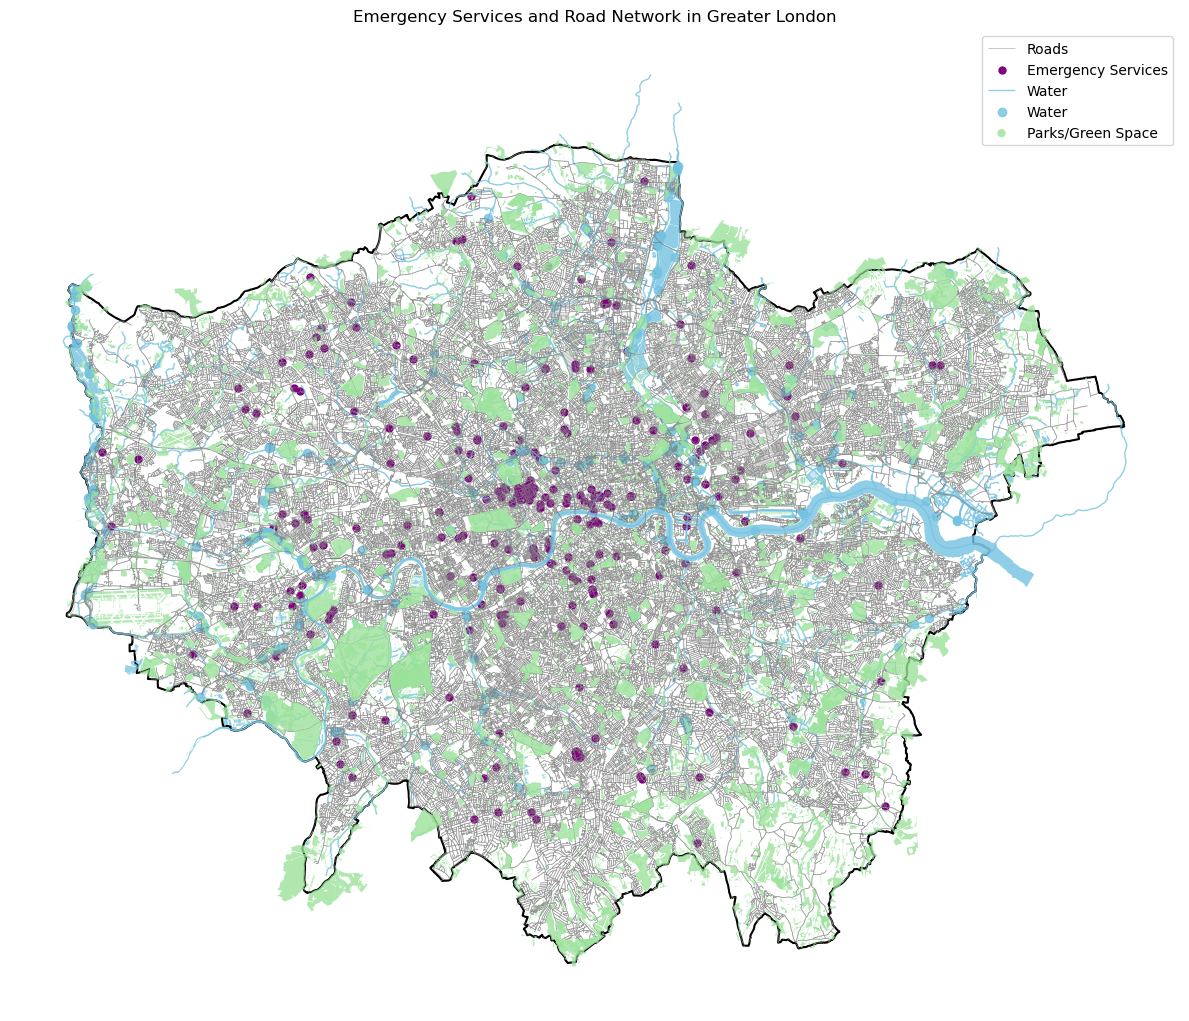

In [21]:
# Converting road graph to GeoDataFrames and reprojecting to EPSG:32630 for consistency with others
edges = ox.graph_to_gdfs(roads, nodes=False, edges=True)
edges = edges.to_crs(epsg=TARGET_EPSG)  


fig, ax = plt.subplots(figsize=(12, 12))

# Plotting London boundary
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, label='London Boundary')

# Plotting Road network
edges.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.6, label='Roads')

# Plotting Emergency services as Purple markers
gdf_services.plot(ax=ax, color='purple', markersize=25, label='Emergency Services')

# Plotting Waterways as blue lines
water_clean = water[~water.geometry.is_empty]
water_clean.plot(ax=ax, color='#74c2e1', linewidth=1, alpha=0.8, label="Water", zorder=1)

# Plotting Parks and green areas with green lines
parks_clean = parks[~parks.geometry.is_empty]
parks_clean.plot(ax=ax, color='#9be29b', edgecolor='none', alpha=0.8, label="Parks/Green Space", zorder=2)

# Final plot settings
plt.title("Emergency Services and Road Network in Greater London")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


## Extracting Accidents in London 2023

**We extracted the accidents data from data.gov.uk and stored it in a excel file. We use this file and filter it for police force 1 and 48 which are for London.** 

This creates a cleaned and spatially accurate dataset of road accident points in Greater London

In [25]:
# Loading and filtering accident data from Excel
accidents_df = pd.read_excel("london_accidents_2023.xlsx")
accidents_df = accidents_df.dropna(subset=['longitude', 'latitude'])
accidents_df = accidents_df[accidents_df['police_force'].isin([1, 48])]

accidents_gdf = gpd.GeoDataFrame(
    accidents_df,
    geometry=gpd.points_from_xy(accidents_df['longitude'], accidents_df['latitude']),
    crs="EPSG:4326"
).to_crs(epsg=TARGET_EPSG)

We download two raster data for London using Global Human Settlement Layer (GHSL). We download two raster tiles that cover the whole of London and then merge them together. 

Resolution: 30 arc-seconds (~1 km at equator)

Format: GeoTIFF

Year: 2025 (projected)

We reprojected the London boundary to EPSG:4326 and clipped the merged raster using rasterio library to account for Greater London. We save the clipped raster to use it in the analysis ahead. 

In [28]:
# Merging population raster tiles (30 arc-second resolution from GHSL)
raster_paths = [
    os.path.join("GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0_R4_C18", "GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0_R4_C18.tif"),
    os.path.join("GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0_R4_C19", "GHS_POP_E2025_GLOBE_R2023A_4326_30ss_V1_0_R4_C19.tif")
]

# Opening raster files and merging them for London 
rasters = [rasterio.open(path) for path in raster_paths]
merged_pop, merged_transform = merge(rasters)

# Saving merged raster to file
merged_raster_path = "london_population_merged.tif"
merged_meta = rasters[0].meta.copy()
merged_meta.update({
    "height": merged_pop.shape[1],
    "width": merged_pop.shape[2],
    "transform": merged_transform
})

with rasterio.open(merged_raster_path, "w", **merged_meta) as dst:
    dst.write(merged_pop)

# Converting London boundary to GeoJSON-like geometry using unary_union
boundary_wgs84 = boundary.to_crs("EPSG:4326")
boundary_geometry = [mapping(boundary_wgs84.unary_union)]

# Clipping the merged raster to the boundary
with rasterio.open(merged_raster_path) as src:
    clipped_pop, clipped_transform = mask(src, boundary_geometry, crop=True)
    clipped_meta = src.meta.copy()

# Updating metadata for clipped raster
clipped_meta.update({
    "height": clipped_pop.shape[1],
    "width": clipped_pop.shape[2],
    "transform": clipped_transform
})

# Save clipped raster
clipped_raster_path = "london_population_clipped.tif"
with rasterio.open(clipped_raster_path, "w", **clipped_meta) as dst:
    dst.write(clipped_pop)

print("Population raster successfully merged and clipped to Greater London.")


Population raster successfully merged and clipped to Greater London.


C:\Users\saad\AppData\Local\Temp\ipykernel_46872\2988684837.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_geometry = [mapping(boundary_wgs84.unary_union)]


**We now use the previously created datasets including the London Raste File to create layered geospatial map showing how population density, emergency service infrastructure, and accident hotspots spatially relate across Greater London**

C:\Users\saad\AppData\Local\Temp\ipykernel_46872\698213267.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


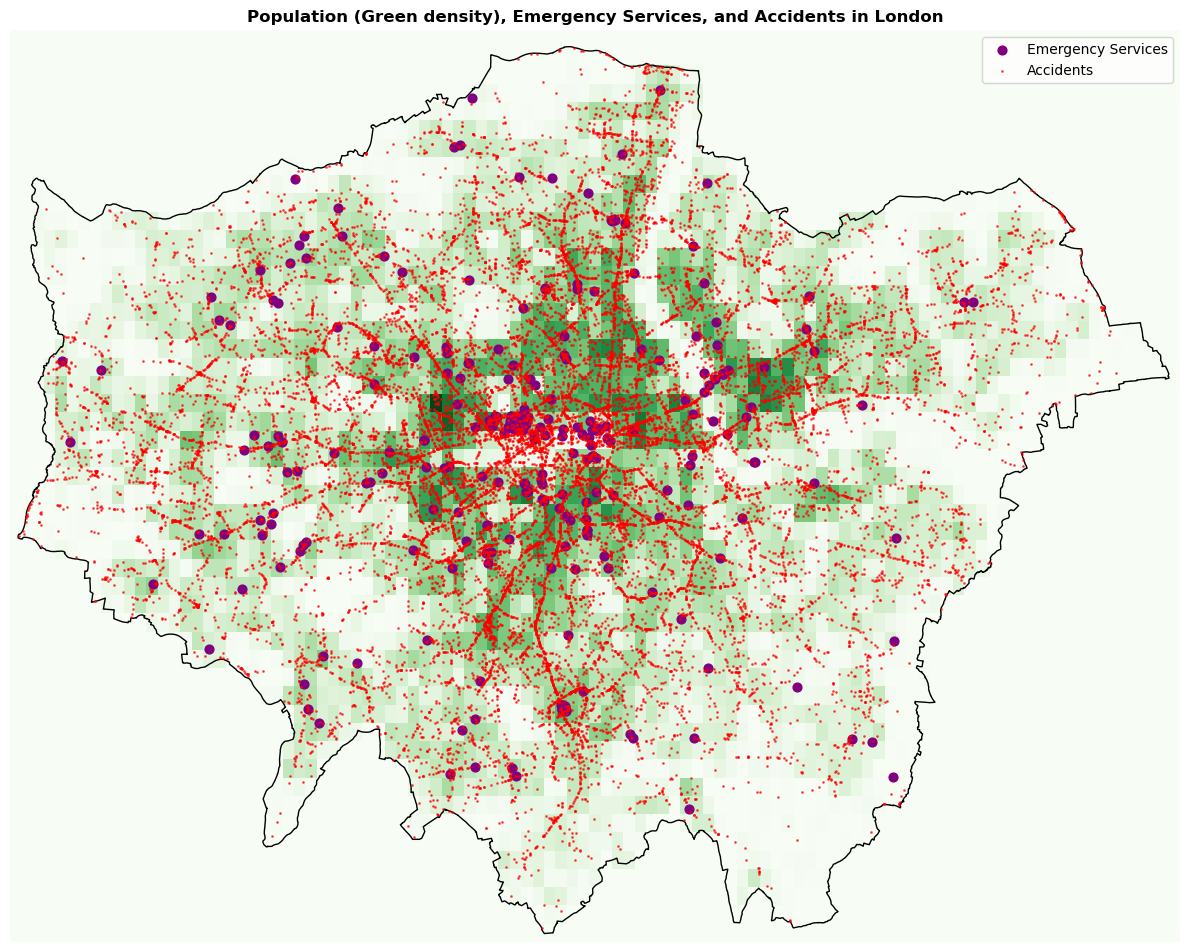

In [30]:

# Loading raster (already in EPSG:4326)
pop_src = rasterio.open("london_population_clipped.tif")

# Reprojecting vector layers to match the raster
boundary_4326 = boundary.to_crs("EPSG:4326")
gdf_services_4326 = gdf_services.to_crs("EPSG:4326")
accidents_gdf_4326 = accidents_gdf.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 12))

# Extracting different elements to plot

# Population Raster
show(pop_src, ax=ax, cmap='Greens', title="Population (Green density), Emergency Services, and Accidents in London")

# London Boundary
boundary_4326.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='London Boundary')

# Emergency Services
gdf_services_4326.plot(ax=ax, color='purple', markersize=40, label='Emergency Services')

# Accidents
accidents_gdf_4326.plot(ax=ax, color='red', markersize=1, alpha=0.6, label='Accidents')

# 5. Finalize Plot
plt.legend()
plt.axis('off')
plt.tight_layout()


In [31]:
print(boundary.crs)
print(pop_src.crs)
print(gdf_services.crs)
print(accidents_gdf.crs)


EPSG:32630
EPSG:4326
EPSG:32630
EPSG:32630


## Simplified Map for Spatial Analysis

We reproject all the necessary elements like boundary, services and accidents to EPSG 32630. 

This ensures all layers are in UTM Zone 30N (meters), which is best for:

Accurate distance-based operations (e.g., buffers, coverage zones)

Spatial analysis (scoring, spatial joins).

We remove elements like roads, waterways and population density to create a clean layer setup for spatial analysis.

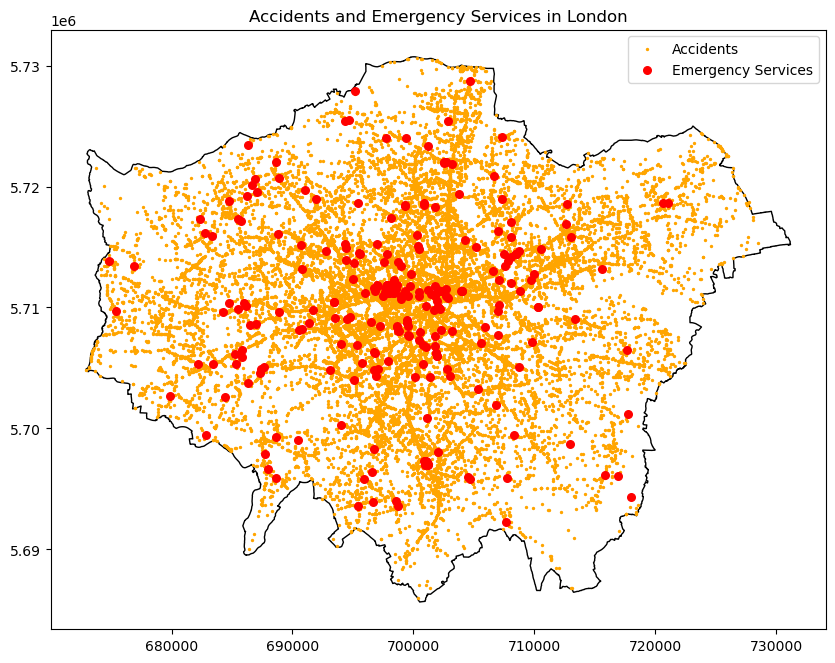

In [34]:
# Reprojecting data
gdf_services = emergency_services[emergency_services.geometry.type == 'Point'].to_crs(epsg=32630)
boundary = boundary.to_crs(epsg=32630)
accidents_gdf = accidents_gdf.to_crs(epsg=32630)

# Quick plot of accident density


fig, ax = plt.subplots(figsize=(10, 10))
boundary.plot(ax=ax, facecolor='none', edgecolor='black')
accidents_gdf.plot(ax=ax, color='orange', markersize=2, label='Accidents')
gdf_services.plot(ax=ax, color='red', markersize=30, label='Emergency Services')
plt.legend()
plt.title("Accidents and Emergency Services in London")
plt.show()



# Analytical Steps

## Create buffers and spatial index

**Here we choose an arbitrary distance of 2 km and create coverage buffers around each existing emergency service location using this fixed-radius buffer. This allows filtering out candidate locations already within reach of existing facilities, improving the relevance of proposed sites. We also create a R-tree spatial index for proximity queries.**

In [38]:
buffer_distance = 2000  # 2km coverage
gdf_services['buffer'] = gdf_services.geometry.buffer(buffer_distance)

# R-tree index
idx = index.Index()
for i, geom in enumerate(gdf_services.geometry):
    idx.insert(i, geom.bounds)


## Generate grid and find underserved zones

**The candidate locations for new emergency service satisfy the below criteria:**

1. Fall within the Greater London boundary

2. Are not within the coverage area (2 km buffer) of any existing emergency service facility

3. Are spaced on a 1 km x 1 km grid

In [41]:
# Creating grid of potential new facility locations
grid_size = 1000
xmin, ymin, xmax, ymax = boundary.total_bounds
x_coords = np.arange(xmin, xmax, grid_size)
y_coords = np.arange(ymin, ymax, grid_size)

candidate_points = []
for x in x_coords:
    for y in y_coords:
        pt = Point(x, y)
        if boundary.unary_union.contains(pt):
            # Must NOT be within existing buffers
            if not any(pt.within(buf) for buf in gdf_services['buffer']):
                candidate_points.append(pt)

# Convert to GeoDataFrame
candidates_gdf = gpd.GeoDataFrame(geometry=candidate_points, crs=gdf_services.crs)


C:\Users\saad\AppData\Local\Temp\ipykernel_46872\1287941030.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if boundary.unary_union.contains(pt):


C:\Users\saad\AppData\Local\Temp\ipykernel_46872\2905982399.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=9, frameon=True)


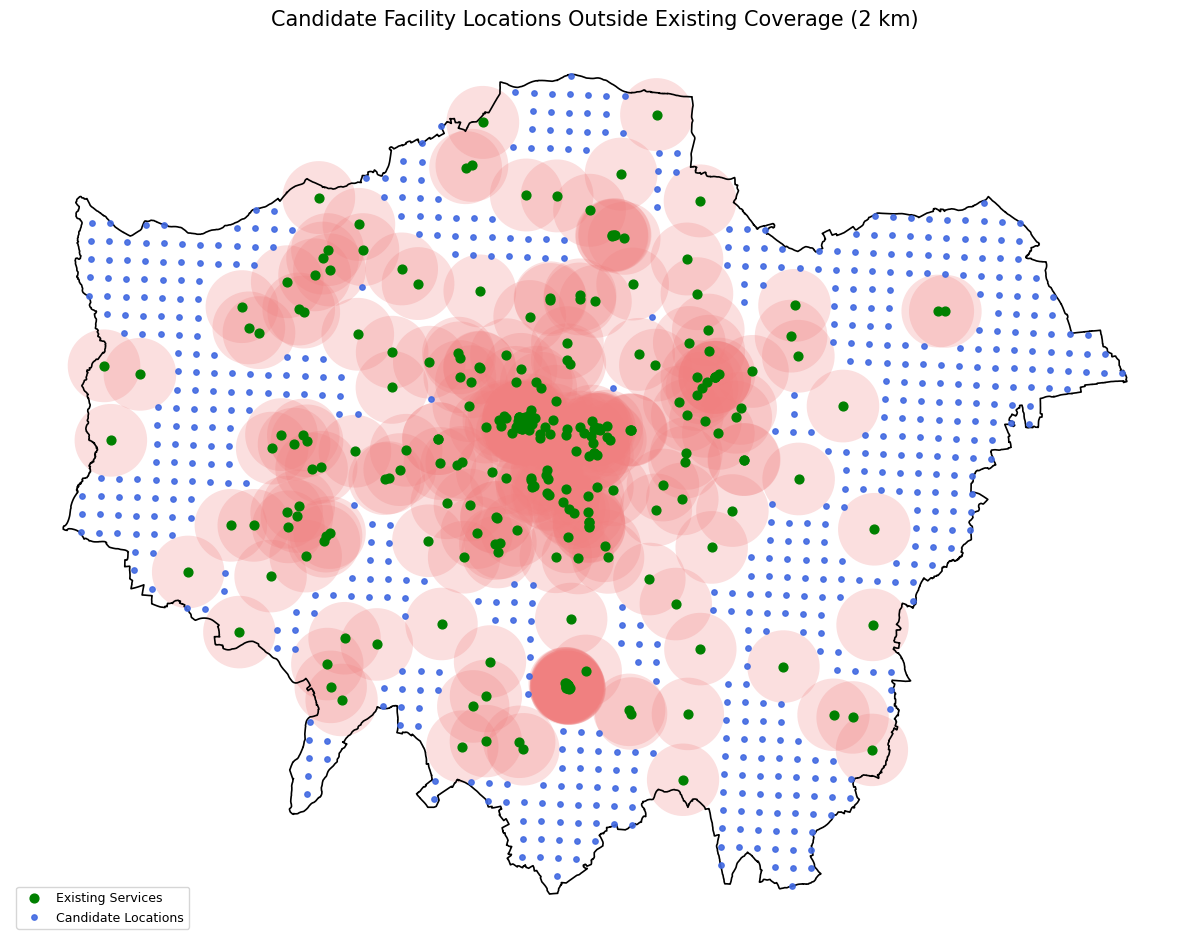

In [42]:
# Reproject all data to EPSG:3857 for clean plotting
boundary_web = boundary.to_crs(epsg=3857)
gdf_services_web = gdf_services.to_crs(epsg=3857)
candidates_web = candidates_gdf.to_crs(epsg=3857)
buffers_web = gdf_services['buffer'].to_crs(epsg=3857)

# Plot setup
fig, ax = plt.subplots(figsize=(12, 12))

# 2km Coverage Buffers
buffers_web.plot(ax=ax, color='lightcoral', alpha=0.25, label='Existing Coverage (2 km)', zorder=1)

# London Boundary
boundary_web.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, label="London Boundary", zorder=2)

# Existing Emergency Services
gdf_services_web.plot(ax=ax, color='green', markersize=40, label='Existing Services', zorder=3)

# Candidate Locations (outside coverage)
candidates_web.plot(ax=ax, color='royalblue', markersize=15, alpha=0.9, label='Candidate Locations', zorder=4)

# Final styling
plt.title("Candidate Facility Locations Outside Existing Coverage (2 km)", fontsize=15)
plt.legend(loc='lower left', fontsize=9, frameon=True)
plt.axis('off')
plt.tight_layout()
plt.show()


## Score candidates using Accidents Proximity, Population Density and Accessibility

**The scoring criteria for a candidate location (created already in last step) depends on:**

1. High accident density nearby

2. High population density

3. Accessibility from road (within 100 m)

4. No overlap with existing service coverage within 2 km (filtered earlier)

In this code accident scores are calculated by seeing the frequency of accidents with in 2 km radius.
The population density is checked at approximately ~1 km^2. As we extract the population value at the exact raster cell that contains each candidate point and we are using 30 arc-seconds resolution which is ~ 1 km vs 1km at equator and we are operating slightly north of it. We also check if the candidate point is within 100m of a road.

We scale the population density and accidents before computing score as they will be in different units.

Currently, we give a **weightage (importance) of 0.7 to accidents and 0.3 to population density** for score calculation for our proposed emergency service site.

In [45]:
# Ensuring candidate and accident points match CRS of population raster (EPSG:4326)
candidates_gdf = candidates_gdf.to_crs(pop_src.crs)
accidents_gdf = accidents_gdf.to_crs(pop_src.crs)
roads_4326 = edges.to_crs(pop_src.crs)  # Reproject roads too

# Clipping accident points to the London boundary
boundary_4326 = boundary.to_crs(pop_src.crs) 
accidents_gdf = accidents_gdf[accidents_gdf.within(boundary_4326.unary_union)]

# Filtering candidates based on road accessibility

road_buffer = roads_4326.buffer(100)  # 100m accessibility buffer

# Keeping all candidate points
accessible_candidates = []
for pt in candidates_gdf.geometry:
    accessible_candidates.append(pt)

# Updating candidate GeoDataFrame
candidates_gdf = gpd.GeoDataFrame(geometry=accessible_candidates, crs=pop_src.crs)
print(f"{len(candidates_gdf)} accessible candidate sites retained.")

# Extracting Sample population from raster
pop_coords = [(pt.x, pt.y) for pt in candidates_gdf.geometry]
pop_values = [val[0] for val in pop_src.sample(pop_coords)]
candidates_gdf['pop_density'] = np.nan_to_num(pop_values, nan=0)

# ---- Accident scoring using candidate buffers ----

# Reproject everything to metric CRS (EPSG:32630) for distance calculations
candidates_m_geom = candidates_gdf.to_crs(epsg=32630).geometry
accidents_m = accidents_gdf.to_crs(epsg=32630)

# Only keep Point geometries from accident data
accident_points = [pt for pt in accidents_m.geometry if isinstance(pt, Point)]


#print("Accident points loaded:", len(accident_points))
#print("Candidate bounds (EPSG:32630):", candidates_m_geom.total_bounds)
#print("Accident bounds (EPSG:32630):", accidents_m.total_bounds)
#print("Example candidate point:", candidates_m_geom.iloc[0])
#print("Example accident point:", accident_points[0])
#print("Sample distance:", candidates_m_geom.iloc[0].distance(accident_points[0]))

# Create buffers around each candidate
buffer_radius = 2000  # meters
accident_counts = []

for i, pt in enumerate(candidates_m_geom):
    pt_buffer = pt.buffer(buffer_radius)
    count = sum(acc_pt.within(pt_buffer) for acc_pt in accident_points)
    accident_counts.append(count)
    
    #if count > 0:
    #    print(f"Candidate {i} at {pt} has {count} accidents within {buffer_radius / 1000} km.")

# Reconstruct final candidate GeoDataFrame
candidates_m = gpd.GeoDataFrame({
    'geometry': candidates_m_geom,
    'pop_density': candidates_gdf['pop_density'].values,
    'accident_score': accident_counts
}, crs="EPSG:32630")

# Normalizing both Accidents and Population for same units and fair scoring
scaler = MinMaxScaler()
candidates_m[['pop_density_norm', 'accident_score_norm']] = scaler.fit_transform(
    candidates_m[['pop_density', 'accident_score']]
)

# ---- Final weighted score ----
candidates_m['score'] = (
    0.7 * candidates_m['accident_score_norm'] +
    0.3 * candidates_m['pop_density_norm']
)

# Sample output
candidates_m[['pop_density', 'accident_score', 'score']].sort_values(by = 'score', ascending = False).head()


C:\Users\saad\AppData\Local\Temp\ipykernel_46872\1713490062.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  accidents_gdf = accidents_gdf[accidents_gdf.within(boundary_4326.unary_union)]
C:\Users\saad\AppData\Local\Temp\ipykernel_46872\1713490062.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_buffer = roads_4326.buffer(100)  # 100m accessibility buffer


647 accessible candidate sites retained.
Candidate 0 at POINT (673920.2076624214 5704642.414560586) has 24 accidents within 2.0 km.
Candidate 1 at POINT (673920.2076624215 5705642.414560587) has 37 accidents within 2.0 km.
Candidate 2 at POINT (673920.2076624215 5706642.414560587) has 45 accidents within 2.0 km.
Candidate 3 at POINT (673920.2076624215 5717642.414560587) has 5 accidents within 2.0 km.
Candidate 4 at POINT (673920.2076624215 5718642.414560586) has 7 accidents within 2.0 km.
Candidate 5 at POINT (673920.2076624215 5719642.414560586) has 7 accidents within 2.0 km.
Candidate 6 at POINT (673920.2076624215 5720642.414560587) has 2 accidents within 2.0 km.
Candidate 7 at POINT (673920.2076624215 5721642.414560586) has 2 accidents within 2.0 km.
Candidate 8 at POINT (674920.2076624215 5704642.414560586) has 25 accidents within 2.0 km.
Candidate 9 at POINT (674920.2076624215 5705642.414560586) has 40 accidents within 2.0 km.
Candidate 10 at POINT (674920.2076624215 5706642.41456

pop_density  accident_score     score
297  9301.593555             658  1.000000
230  8420.888848             510  0.814148
229  7552.695631             532  0.809551
228  7640.502295             489  0.766638
246  6086.744099             508  0.736738

In [46]:
candidates_m.sort_values(by = 'accident_score', ascending = False).head()

geometry  pop_density  accident_score  \
297  POINT (702920.208 5713642.415)  9301.593555             658   
229  POINT (697920.208 5701642.415)  7552.695631             532   
230  POINT (697920.208 5702642.415)  8420.888848             510   
246  POINT (698920.208 5701642.415)  6086.744099             508   
228  POINT (697920.208 5700642.415)  7640.502295             489   

     pop_density_norm  accident_score_norm     score  
297          1.000000             1.000000  1.000000  
229          0.811979             0.808511  0.809551  
230          0.905317             0.775076  0.814148  
246          0.654376             0.772036  0.736738  
228          0.821419             0.743161  0.766638

# Solution Presentation

C:\Users\saad\AppData\Local\Temp\ipykernel_46872\2311925165.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=14, frameon=True, labelspacing=1.2)


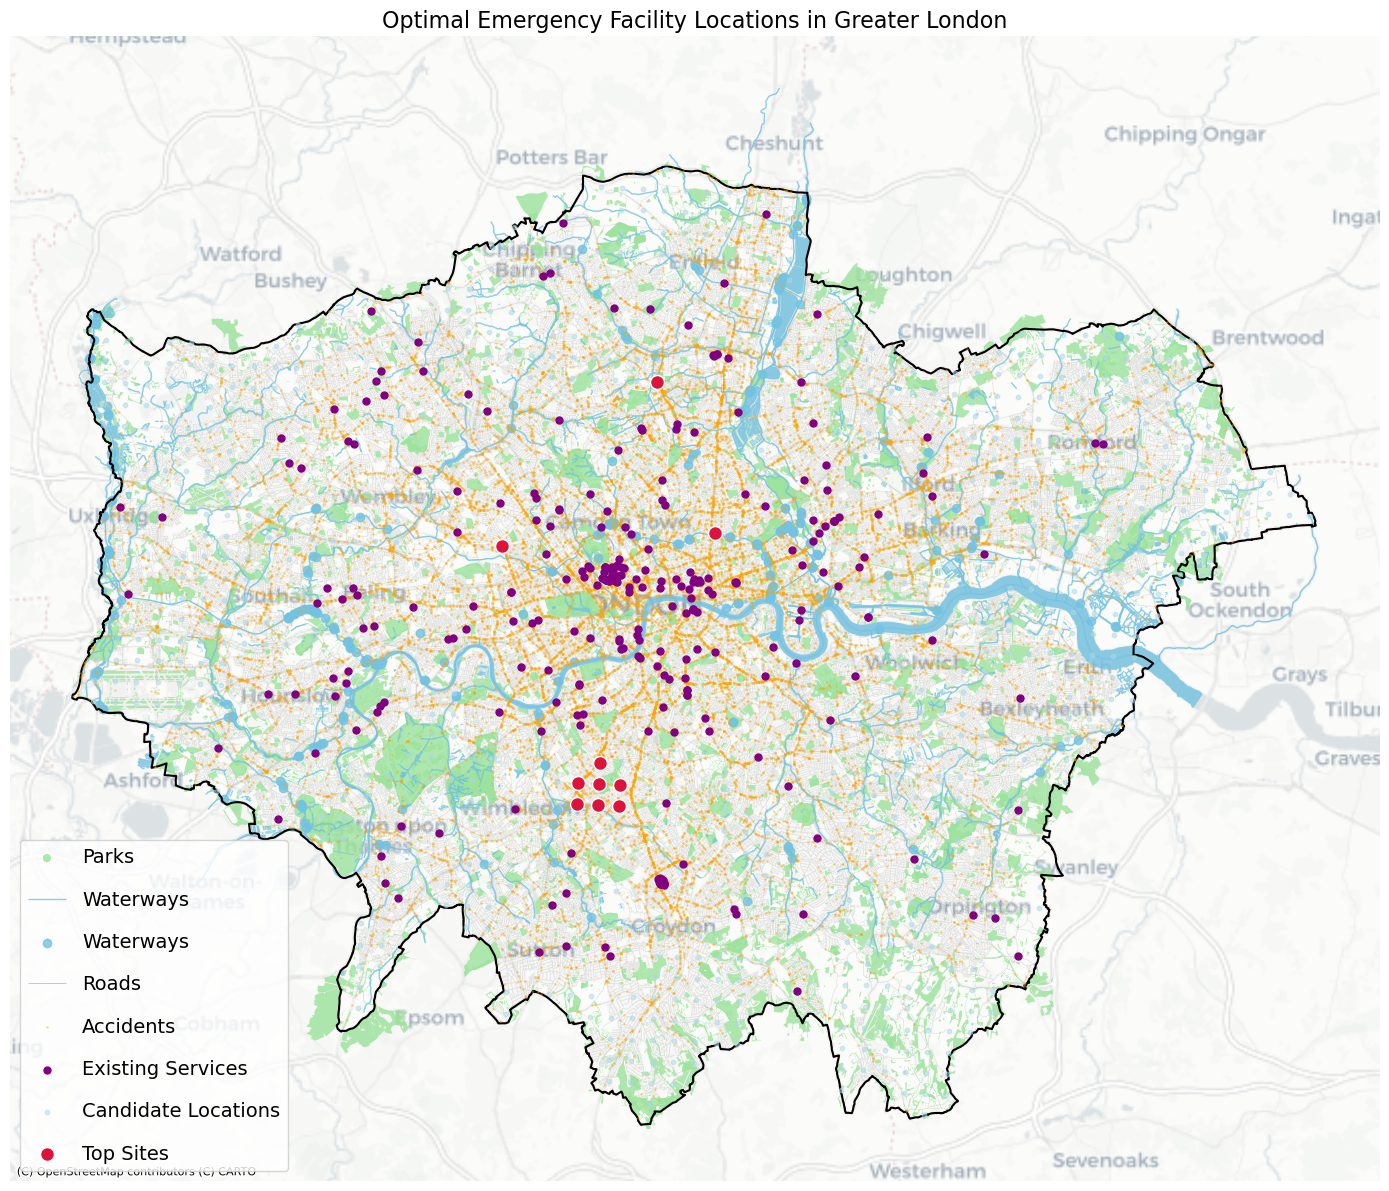

In [48]:
# Selecting top 10 candidate sites based on score
top_sites = candidates_m.sort_values("score", ascending=False).head(10)

# Reprojecting all layers to EPSG:3857 (Web Mercator) for basemap compatibility
boundary_web = boundary.to_crs(epsg=3857)
gdf_services_web = gdf_services.to_crs(epsg=3857)
candidates_web = candidates_gdf.to_crs(epsg=3857)
top_sites_web = top_sites.to_crs(epsg=3857)
accidents_web = accidents_gdf.to_crs(epsg=3857)
edges_web = edges.to_crs(epsg=3857)
parks_web = parks.to_crs(epsg=3857)
water_web = water.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(14, 14))

# --- Context layers ---
parks_web.plot(ax=ax, color='#9be29b', edgecolor='none', alpha=0.8, label='Parks', zorder=1)
water_web.plot(ax=ax, color='#74c2e1', linewidth=1, alpha=0.8, label='Waterways', zorder=2)
edges_web.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.6, label='Roads', zorder = 0)


# --- Main Layers ---
boundary_web.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, label="London Boundary", zorder=3)
accidents_web.plot(ax=ax, color='orange', markersize=1, alpha=0.3, label='Accidents', zorder=4)
gdf_services_web.plot(ax=ax, color='purple', markersize=25, label='Existing Services', zorder=5)
candidates_web.plot(ax=ax, color='lightblue', markersize=10, alpha=0.5, label='Candidate Locations', zorder=6)

# Highlighting Top 10 Candidates
top_sites_web.plot(
    ax=ax,
    color='crimson',
    markersize=100,
    edgecolor='white',
    linewidth=1,
    label='Top Sites',
    zorder=7
)

# Adding basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)

plt.title("Optimal Emergency Facility Locations in Greater London", fontsize=16)
plt.legend(loc='lower left', fontsize=14, frameon=True, labelspacing=1.2)
plt.axis('off')
plt.tight_layout()
plt.show()


## Additional Information on Candidate Sites

In [50]:
# Convert to WGS84 (EPSG:4326) for readable lat/lon
top_sites_latlon = top_sites.to_crs(epsg=4326)

# Extract lat/lon from geometry
top_sites_latlon['longitude'] = top_sites_latlon.geometry.x
top_sites_latlon['latitude'] = top_sites_latlon.geometry.y


In [51]:
geolocator = Nominatim(user_agent="london_emergency_sites")

# Creating a function for reverse geocoding
def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        return location.address if location else None
    except:
        return None

# Applying reverse geocoding 
top_sites_latlon['address'] = top_sites_latlon.apply(
    lambda row: reverse_geocode(row['latitude'], row['longitude']),
    axis=1
)


In [52]:
info_cols = ['latitude', 'longitude', 'pop_density','pop_density_norm', 'accident_score','accident_score_norm', 'score', 'address']
summary_info = top_sites_latlon[info_cols].copy()
summary_info = summary_info.round(4).sort_values("score", ascending=False).reset_index(drop=True)
summary_info

latitude  longitude  pop_density  pop_density_norm  accident_score  \
0   51.5374    -0.0739    9301.5936            1.0000             658   
1   51.4403    -0.1521    8420.8888            0.9053             510   
2   51.4314    -0.1527    7552.6956            0.8120             532   
3   51.4224    -0.1532    7640.5023            0.8214             489   
4   51.4310    -0.1383    6086.7441            0.6544             508   
5   51.4220    -0.1389    7860.2155            0.8450             443   
6   51.4317    -0.1670    9033.1327            0.9711             407   
7   51.4227    -0.1676    7617.8578            0.8190             429   
8   51.6013    -0.1132    7716.3110            0.8296             398   
9   51.5319    -0.2185    5539.8399            0.5956             436   

   accident_score_norm   score  \
0               1.0000  1.0000   
1               0.7751  0.8141   
2               0.8085  0.8096   
3               0.7432  0.7666   
4               0.7720  0.7367   
5               0.6733  0.7248   
6               0.6185  0.7243   
7               0.6520  0.7021   
8               0.6049  0.6723   
9               0.6626  0.6425   

                                             address  
0  41-47, Richardson Close, Stonebridge Estate, H...  
1  70, Cheriton Square, Upper Tooting, Balham, Lo...  
2  Henry Doulton Drive, Heritage Park, Furzedown,...  
3  Furzedown Primary School, Beclands Road, Strea...  
4  Tooting Bec Road, Manor Park, Streatham, Londo...  
5  Eardley Road, Streatham Park, Furzedown, Londo...  
6  Hereward Road, Upper Tooting, Furzedown, Londo...  
7  101, Trevelyan Road, Tooting Graveney, Furzedo...  
8  Neville Place, London Borough of Haringey, Lon...  
9  13, Mortimer Road, Brondesbury, London Borough...